# Demo: Exploring and Visualizing River Water Quality Data (Hubeau API)

This notebook shows how to:
- Automatically find a station and parameter with a rich time series,
- Visualize the resulting data,
- Prepare for advanced analysis and visualizations.


## 1. Imports & Client Initialization


In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from hubeau_py.client import HubeauClient

client = HubeauClient()


## 2. Automatically Find a Station and Parameter with Many Data Points

We will:
- Retrieve a sample of stations,
- For each station, count the number of measurements per parameter,
- Select the (station, parameter) combination with the richest time series.


In [2]:
stations = client.qualite_rivieres.get_stations(size=50)
codes = [s.code_station for s in stations if s.code_station]

best_station = None
best_param = None
max_points = 0
best_df = None

for code in codes:
    analyses = client.qualite_rivieres.get_analyses(
        code_station=code, size=100, max_records=1000
    )
    if not analyses:
        continue
    df = pd.DataFrame([a.model_dump() for a in analyses])
    if df.empty or 'libelle_parametre' not in df:
        continue
    counts = df['libelle_parametre'].value_counts()
    top_param = counts.idxmax()
    num_points = counts.max()
    if num_points > max_points:
        max_points = num_points
        best_station = code
        best_param = top_param
        best_df = df
    print(f"Station {code}: {top_param} ({num_points} points)")
    if num_points > 40:  # Stop early if very rich
        break

print(f"\nBest station: {best_station}, parameter: {best_param}, points: {max_points}")


Station ----1543: Potentiel en Hydrogène (pH) (113 points)

Best station: ----1543, parameter: Potentiel en Hydrogène (pH), points: 113


## 3. Plot the Time Series for the Best Combination

Let's visualize the time series for the selected station and parameter.


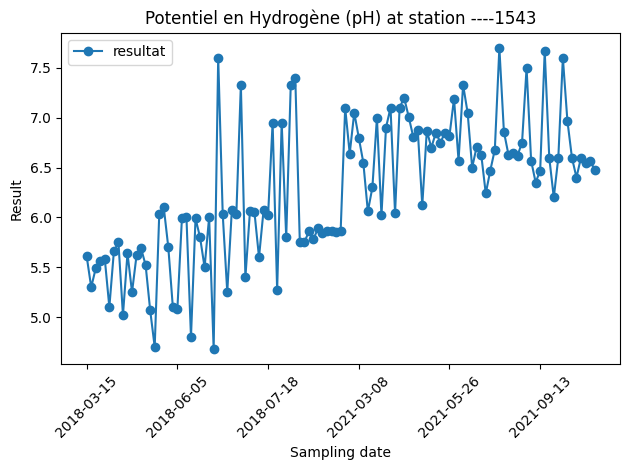

In [3]:
if best_df is not None and best_param is not None:
    plot_df = best_df[best_df['libelle_parametre'] == best_param]\
        .sort_values('date_prelevement')
    plot_df.plot(x='date_prelevement', y='resultat', marker='o')
    plt.title(f"{best_param} at station {best_station}")
    plt.ylabel("Result")
    plt.xlabel("Sampling date")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No suitable data found.")
